# Initializing and training GPT-2 model

In [1]:
from tqdm import tqdm
from datasets import load_dataset, DatasetDict, load_from_disk
from transformers import BertTokenizer, BertForMaskedLM, GPT2Tokenizer, GPT2Config, GPT2Model, GPT2LMHeadModel, GPT2LMHeadModel
from transformers import DataCollatorForLanguageModeling, DataCollatorWithPadding
from transformers import Trainer, TrainingArguments
import random

/Users/krmkrm/mit/meng/repos/context_and_reduction/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading in the data

In [2]:
def load_data_in_splits(data_dir, train=0.8, val=0.1, test=0.1):
    data = load_dataset(data_dir)
    train_valtest = data['train'].train_test_split(test_size = 1 - train)
    test_valid = train_valtest['test'].train_test_split(test_size = test / (val + test))
    out = DatasetDict({
            'train': train_valtest['train'],
            'val': test_valid['train'],
            'test': test_valid['test']
        })
    return out

coca_dir = "../data/coca_spoken/text_cleaned/"

coca_dsdict = load_data_in_splits(coca_dir, .8, .1, .1)
coca_dsdict

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 4802969
    })
    val: Dataset({
        features: ['text'],
        num_rows: 600371
    })
    test: Dataset({
        features: ['text'],
        num_rows: 600372
    })
})

In [3]:
for split in ['train', 'val', 'test']:
    print(split, random.choice(coca_dsdict[split]))

train {'text': 'Yes .'}
val {'text': 'I think she has a lot of guilt , which leads to her grief , OK .'}
test {'text': 'On the -- there you go , on the pasta .'}


### Data stats

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plot_data = coca_dsdict['test']

# 1. Sentence Length Distribution
def get_sentence_lengths(data):
    return pd.DataFrame(len(s) for s in data['text'])

plot_lengths = get_sentence_lengths(plot_data)

         0
0.25  28.0
0.50  54.0
0.75  98.0


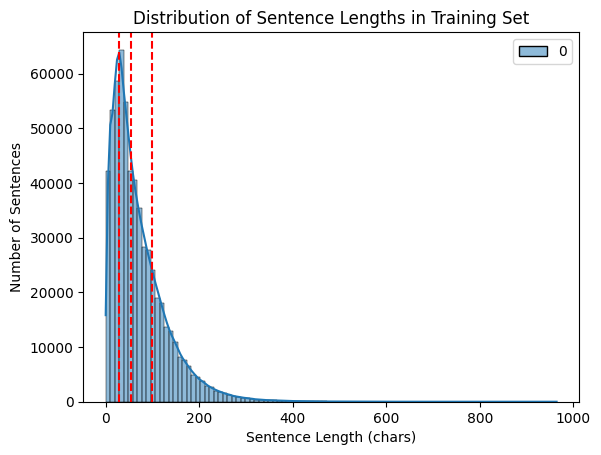

In [47]:
# sns.displot(train_lengths, kde=True)
quantiles = plot_lengths.quantile([.25, .5, .75])
print(quantiles)
sns.histplot(plot_lengths, bins=100, kde=True)
for q in quantiles.values:
    plt.axvline(q, 0, 1, color='r', ls='--')
plt.xlabel("Sentence Length (chars)")
plt.ylabel("Number of Sentences")
plt.title("Distribution of Sentence Lengths in Training Set")
plt.show()

## Tokenization

In [11]:
context_length = 1024
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

In [ ]:
outputs = tokenizer(
    coca_dsdict["train"][:2]["text"],
    truncation=True,
    max_length=context_length,
    return_overflowing_tokens=True,
    return_length=True,
)

In [55]:
print(f"Input IDs length: {len(outputs['input_ids'])}")
print(f"Input chunk lengths: {(outputs['length'])}")
print(outputs['input_ids'])
print(coca_dsdict['train'][:2]['text'])
print([tokenizer.convert_ids_to_tokens(sentence) for sentence in outputs['input_ids']])

Input IDs length: 2
Input chunk lengths: [6, 10]
[[1544, 7224, 1243, 845, 2092, 764], [1544, 4966, 257, 845, 1913, 3234, 287, 968, 13910, 764]]
['He sees things very similar .', 'He ran a very strong race in New Hampshire .']
[['He', 'Ġsees', 'Ġthings', 'Ġvery', 'Ġsimilar', 'Ġ.'], ['He', 'Ġran', 'Ġa', 'Ġvery', 'Ġstrong', 'Ġrace', 'Ġin', 'ĠNew', 'ĠHampshire', 'Ġ.']]


In [5]:
tokenized_data_path = '../data/coca_spoken/tokens/'

In [58]:
encoded_datasets = coca_dsdict.map(lambda sentence: tokenizer(sentence['text']), batched=True)
encoded_datasets.save_to_disk(tokenized_data_path)

Saving the dataset (1/1 shards): 100%|██████████| 600372/600372 [00:00<00:00, 1815063.37 examples/s]


In [61]:
print(encoded_datasets)
print(encoded_datasets['train'][0])
print(sum(len(x['input_ids']) for x in encoded_datasets['train']))

DatasetDict({
    train: Dataset({
        features: ['text', 'input_ids', 'attention_mask'],
        num_rows: 4802969
    })
    val: Dataset({
        features: ['text', 'input_ids', 'attention_mask'],
        num_rows: 600371
    })
    test: Dataset({
        features: ['text', 'input_ids', 'attention_mask'],
        num_rows: 600372
    })
})
{'text': 'He sees things very similar .', 'input_ids': [1544, 7224, 1243, 845, 2092, 764], 'attention_mask': [1, 1, 1, 1, 1, 1]}
79275294


### Loading tokenized dataset from disk

In [6]:
encoded_datasets = load_from_disk(tokenized_data_path)

## Init GPT-2 model and config

In [7]:
configuration = GPT2Config()
model = GPT2LMHeadModel(configuration)
configuration = model.config
configuration

GPT2Config {
  "activation_function": "gelu_new",
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "transformers_version": "4.39.2",
  "use_cache": true,
  "vocab_size": 50257
}

In [8]:
model_size = sum(t.numel() for t in model.parameters())
print(f"GPT-2 size: {model_size/1000**2:.1f}M parameters")

GPT-2 size: 124.4M parameters


### Data collator

The data collator will pad the tokens.
Should the tokens be padded beforehand in the tokenizer?
Should the tokens be padded to a specific length?
Should long sentences be truncated or excluded?

In [20]:
tokenizer.pad_token = tokenizer.eos_token
data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=False)
# mlm=True: autoencoding, mlm=False: autoregressive
# data_collator = DataCollatorWithPadding(tokenizer)

In [21]:
for i in range(5):
    print(encoded_datasets['train'][i])

{'text': 'He sees things very similar .', 'input_ids': [1544, 7224, 1243, 845, 2092, 764], 'attention_mask': [1, 1, 1, 1, 1, 1]}
{'text': 'He ran a very strong race in New Hampshire .', 'input_ids': [1544, 4966, 257, 845, 1913, 3234, 287, 968, 13910, 764], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
{'text': 'So what is the significance of all this Mark ?', 'input_ids': [2396, 644, 318, 262, 12085, 286, 477, 428, 2940, 5633], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
{'text': 'And for those who have placed their faith in Jesus Christ , and can claim God as their father , then heaven is going to be their eternal life .', 'input_ids': [1870, 329, 883, 508, 423, 4624, 511, 4562, 287, 5803, 1951, 837, 290, 460, 1624, 1793, 355, 511, 2988, 837, 788, 9538, 318, 1016, 284, 307, 511, 15851, 1204, 764], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
{'text': 'That is all we have time for today .', 'input_ids': [2504, 3

In [23]:
tokenized_datasets = encoded_datasets.remove_columns(coca_dsdict["train"].column_names)

In [25]:
example_data_collation = data_collator([tokenized_datasets['train'][i] for i in range(40)])
for key in example_data_collation:
    print(f"{key} shape: {example_data_collation[key].shape}")

input_ids shape: torch.Size([40, 68])
attention_mask shape: torch.Size([40, 68])
labels shape: torch.Size([40, 68])


## Trainer

In [16]:
import accelerate
import transformers

transformers.__version__, accelerate.__version__

('4.39.2', '0.28.0')

In [17]:
training_output_dir = '../models/test1/'
args = TrainingArguments(training_output_dir)

In [26]:
trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    args=args,
    data_collator=data_collator,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['val'],
)

/Users/krmkrm/mit/meng/repos/context_and_reduction/venv/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [27]:
trainer.train()

RuntimeError: MPS backend out of memory (MPS allocated: 7.50 GB, other allocations: 10.53 GB, max allowed: 18.13 GB). Tried to allocate 147.24 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).